# Thesis Chapter 6.3: Surface Air Temperature Response

In [19]:
import os
import sys
import numpy as np
import xesmf as xe
import xarray as xr
import cmocean
import cartopy
import scipy.stats as stats
import cartopy.crs as ccrs
import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt

In [20]:
%matplotlib inline
mpl.rc_file('../rc_file')
%config InlineBackend.print_figure_kwargs={'bbox_inches':None}
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
sys.path.append("..")
from tqdm import notebook
from paths import path_results, path_prace, CESM_filename, file_ex_atm_lpd
from filters import lowpass
from constants import spy
from constants import R_earth
from xr_regression import xr_linear_trend, xr_lintrend, xr_2D_trends
A_Earth = 4*np.pi*R_earth**2

### surface temperature trend
originally in `GMST.ipynb`

In [22]:
%%time
kw = {'combine':'nested', 'concat_dim':'time', 'decode_times':False}
T_ctrl = xr.open_mfdataset(f'{path_prace}/ctrl/atm_yrly_T_0*.nc', **kw)['T'][:,-1,:,:].mean('time')  # 200-230
T_lpd5 = xr.open_mfdataset(f'{path_prace}/lpd/atm_yrly_T_05*.nc', **kw)['T'][:,-1,:,:].mean('time')  # 500-530
T_lpd1 = xr.open_mfdataset(f'{path_prace}/lpd/atm_yrly_T_1*.nc' , **kw)['T'][:,-1,:,:].mean('time')  # 1190-1220
T_rcp  = xr.open_mfdataset(f'{path_prace}/rcp/atm_yrly_T_T850_U_V_2*.nc', **kw)['T'][:100,-1,:,:]
T_lr1  = xr.open_mfdataset(f'{path_prace}/lr1/atm_yrly_T_T850_U_V_2*.nc', **kw)['T'][:100,-1,:,:]
T_hq   = xr.open_mfdataset(f'{path_prace}/hq/atm_yrly_T_T850_U_V_2*.nc' , **kw)['T'][:,-1,:,:]
T_lq   = xr.open_mfdataset(f'{path_prace}/lq/atm_yrly_T_T850_U_V_2*.nc' , **kw)['T'][:51,-1,:,:]



CPU times: user 4.94 s, sys: 2.27 s, total: 7.21 s
Wall time: 40.1 s


In [23]:
regridder = xe.Regridder(T_rcp, T_lr1, 'bilinear', reuse_weights=True)

Reuse existing file: bilinear_384x576_192x288.nc


AMOC collapses in `lq`?

CPU times: user 1.17 s, sys: 619 ms, total: 1.79 s
Wall time: 2.6 s


Text(0.5, 1.0, 'SAT trend low res quadrupling')

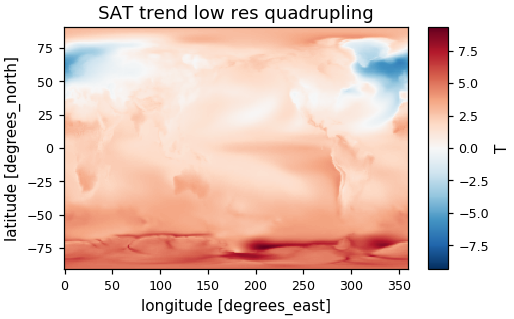

In [24]:
%%time
(xr_2D_trends(xr.open_mfdataset(f'{path_prace}/lq/atm_yrly_T_T850_U_V_2*.nc', **kw)['T'][:,-1,:,:])*100*365).plot(label='SAT trend [K/100yr]')
plt.title('SAT trend low res quadrupling')

#### meridional SAT trend

In [25]:
T_rcp_low = regridder(T_rcp).assign_coords({'time':T_lr1.time})
T_hq_low  = regridder(T_hq) .assign_coords({'time':T_lq .time})
T_rcp_zm = (T_rcp.mean('lon')-T_ctrl.mean('lon'))
T_lr1_zm = (T_lr1.mean('lon')-T_lpd5.mean('lon'))
T_hq_zm  = (T_hq .mean('lon')-T_ctrl.mean('lon'))
T_lq_zm  = (T_lq .mean('lon')-T_lpd1.mean('lon'))
T_rdiff_zm = ((T_rcp_low-T_lr1).mean('lon')-(T_rcp_low-T_lr1).isel(time=slice(0,10)).mean(['lon','time']))
T_qdiff_zm = ((T_hq_low -T_lq ).mean('lon')-(T_hq_low -T_lq ).isel(time=slice(0,10)).mean(['lon','time']))

/home/ajueling/.conda/envs/CESM/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/home/ajueling/.conda/envs/CESM/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


In [26]:
X1, Y1 = np.meshgrid(T_rcp.lat, T_rcp.time/365+2000)
X2, Y2 = np.meshgrid(T_lr1.lat, T_lr1.time/365+2000)
X3, Y3 = np.meshgrid(T_hq .lat, T_hq .time/365+2000)
X4, Y4 = np.meshgrid(T_lq .lat, T_lq .time/365+2000)

In [27]:
letters = 'abcdefg'
for i in range(3):
    print(letters[2*i], letters[2*i+1])

a b
c d
e f


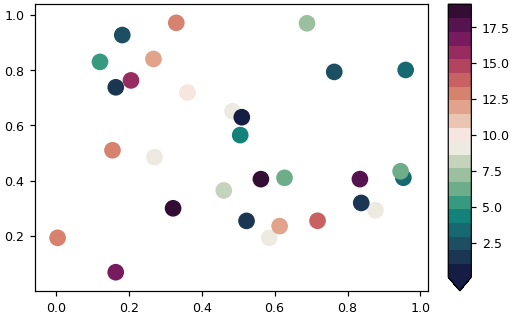

In [28]:
x, y, z = np.random.random((3, 30))
z = z * 20 + 0.1
fig, ax = plt.subplots()
cax = ax.scatter(x, y, c=z, s=100, cmap=plt.get_cmap('cmo.curl',20), vmin=0.1, vmax=z.max())
fig.colorbar(cax, extend='min')

plt.show()

/home/ajueling/.conda/envs/CESM/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.


CPU times: user 5.44 s, sys: 7.55 s, total: 13 s
Wall time: 21 s


/home/ajueling/.conda/envs/CESM/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


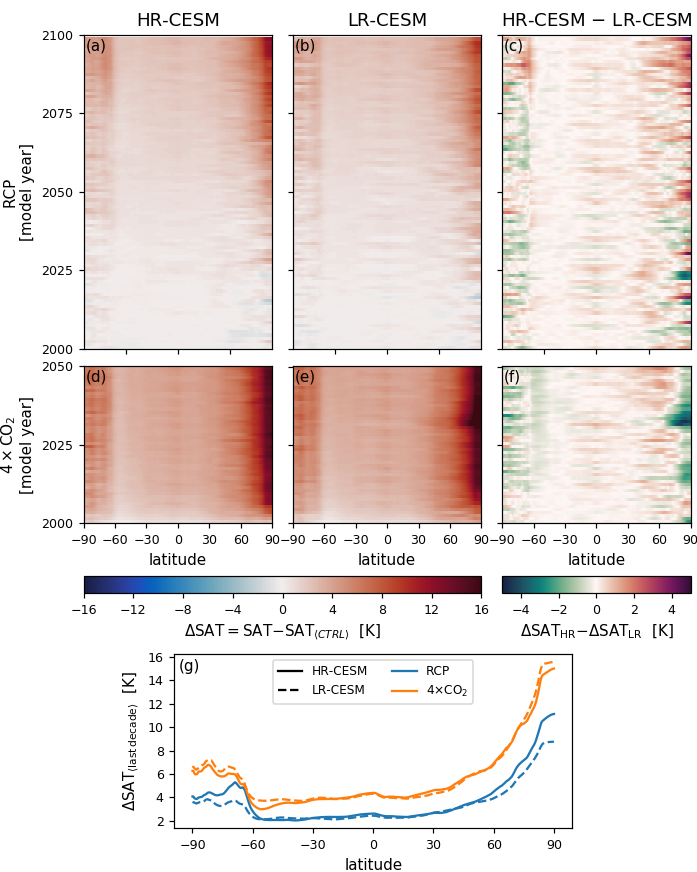

In [29]:
%%time
kw1 = {'vmin':-16, 'vmax':16, 'cmap':'cmo.balance'}  # plt.get_cmap('cmo.balance',32)}
kw2 = {'vmin':-5, 'vmax':5, 'cmap':'cmo.curl'}       # plt.get_cmap('cmo.curl',20)}

f = plt.figure(figsize=(6.4,8))

ascii
# Hovmoeller diagrams
for i in range(3):
    # ax_rcp = f.add_axes([.11,.75-i*.23,.58,.21])
    ax_rcp = f.add_axes([.12+i*.3,.6,.27,.36])
    ax_rcp.set_title(['HR-CESM', 'LR-CESM', r'HR-CESM $-$ LR-CESM'][i])
    (X, Y, kw) = [(X1,Y1,kw1),(X2,Y2,kw1),(X2,Y2,kw2)][i]
    q = [T_rcp_zm, T_lr1_zm, T_rdiff_zm][i]
    im = ax_rcp.pcolormesh(X, Y, q, **kw)
    ax_rcp.set_yticks(np.arange(2000,2101,25))
    if i==0:   ax_rcp.set_yticklabels(np.arange(2000,2101,25))
    else:      ax_rcp.set_yticklabels([])
    ax_rcp.set_xticklabels([])
    ax_rcp.text(.01, .95, '('+'abc'[i]+')', transform=ax_rcp.transAxes)

    ax_q = f.add_axes([.12+i*.3,.4,.27,.18])
    ax_q.set_xlabel('latitude')
    (X, Y, kw) = [(X3,Y3,kw1),(X4,Y4,kw1),(X4,Y4,kw2)][i]
    q = [T_hq_zm, T_lq_zm, T_qdiff_zm][i]
    ax_q.pcolormesh(X, Y, q, **kw)
    ax_q.set_xticks(np.arange(-90,91,30))
    ax_q.set_yticks(np.arange(2000,2051,25))
    if i==0:   ax_q.set_yticklabels(np.arange(2000,2051,25))
    else:      ax_q.set_yticklabels([])
    ax_q.text(.01, .9, '('+'def'[i]+')', transform=ax_q.transAxes)

    for j, ax in enumerate([ax_rcp,ax_q]):
        if i==0:
            ax.set_ylabel(['RCP',r'$4\times\mathrm{CO}_2$'][j]+'\n[model year]')
    
    if i==0:
        cax = f.add_axes([.12,.32,.57,.02])
        label = r'$\Delta$SAT$=$SAT$-$SAT$_{\langle CTRL \rangle}$  [K]'
        cbar = plt.colorbar(im, cax=cax, orientation='horizontal', label=label, ticks=np.arange(-16,17,4))
    if i==2:
        cax = f.add_axes([.72,.32,.27,.02])
        label = r'$\Delta$SAT$_{\mathrm{HR}}$$-\Delta$SAT$_{\mathrm{LR}}$  [K]'
        cbar = plt.colorbar(im, cax=cax, orientation='horizontal', label=label, ticks=np.arange(-4,5,2))

# last decade - CTRL
ax = f.add_axes([.25,.05,.57,.20])
ax.set_xticks(np.arange(-90,91,30))
ax.set_xlabel('latitude')
ax.set_ylabel(r'$\Delta$SAT$_{\langle\mathrm{last\,decade}\rangle}$  [K]')

kw = {'time':slice(-11,-1)}
ax.plot(T_rcp.lat, T_rcp_zm.isel(**kw).mean('time'), ls='-' , c='C0')
ax.plot(T_lr1.lat, T_lr1_zm.isel(**kw).mean('time'), ls='--', c='C0')
ax.plot(T_hq .lat, T_hq_zm .isel(**kw).mean('time'), ls='-' , c='C1')
ax.plot(T_lq .lat, T_lq_zm .isel(**kw).mean('time'), ls='--', c='C1')
ax.plot([],[],c='k', ls='-' , label='HR-CESM')
ax.plot([],[],c='k', ls='--', label='LR-CESM')
ax.plot([],[],c='C0', label='RCP')
ax.plot([],[],c='C1', label=r'4$\times$CO$_2$')
ax.set_yticks(np.arange(2,17,2))
ax.legend(ncol=2, fontsize=8, loc=9)
ax.text(.01, .9, '(g)', transform=ax.transAxes)

plt.savefig(f'{path_results}/thesis/63_SAT_zonal')

TypeError: Dimensions of C (100, 384) are incompatible with X (100) and/or Y (384); see help(pcolormesh)

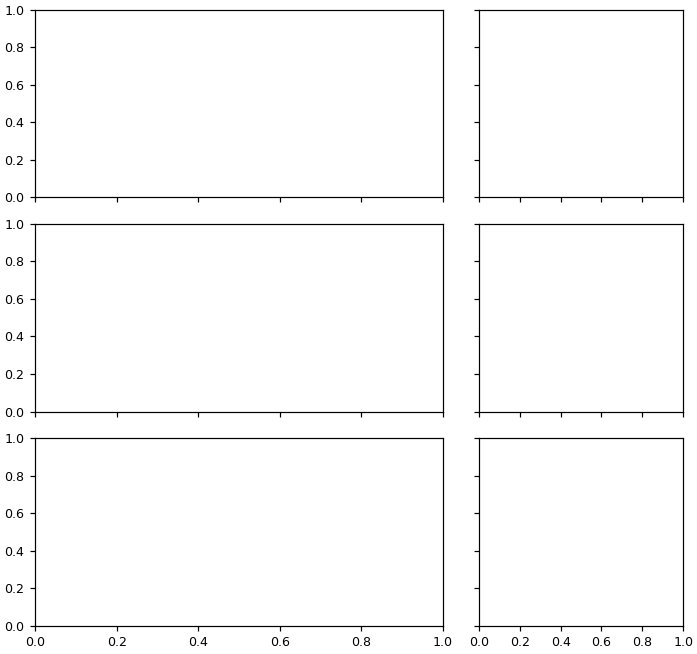

In [30]:
%%time
#21.1 s
f, ax = plt.subplots(3, 2, figsize=(6.4,6), sharex='col', sharey=True,
                     gridspec_kw={'width_ratios':[2,1]}, constrained_layout=True)
kw1 = {'vmin':-15, 'vmax':15, 'cmap':'cmo.balance'}
kw2 = {'vmin':-5, 'vmax':5, 'cmap':'cmo.curl'}
X1, Y1 = np.meshgrid(T_rcp.time/365+2000, T_rcp.lat)
X2, Y2 = np.meshgrid(T_lr1.time/365+2000, T_lr1.lat)
X3, Y3 = np.meshgrid(T_hq .time/365+2000, T_hq .lat)
X4, Y4 = np.meshgrid(T_lq .time/365+2000, T_lq .lat)

ax[0,0].pcolormesh(X1, Y1, T_rcp_zm  , **kw1)
ax[0,1].pcolormesh(X3, Y3, T_hq_zm   , **kw1)
ax[1,0].pcolormesh(X2, Y2, T_lr1_zm  , **kw1)
ax[1,1].pcolormesh(X4, Y4, T_lq_zm   , **kw1)
ax[2,0].pcolormesh(X2, Y2, T_rdiff_zm, **kw2)
ax[2,1].pcolormesh(X4, Y4, T_qdiff_zm, **kw2)
ax[0,0].set_ylabel('HIGH')
ax[1,0].set_ylabel('LOW')
ax[2,0].set_ylabel('HIGH - LOW')
ax[0,0].set_title('RCP')
ax[0,1].set_title('4xCO2')
ax[2,0].set_xlim(2000,2100)
ax[2,1].set_xlim(2000,2050)
for i in range(3):
    ax[i,0].set_yticks(np.arange(-90,91,30))


Text(0.5, 0, 'latitude')

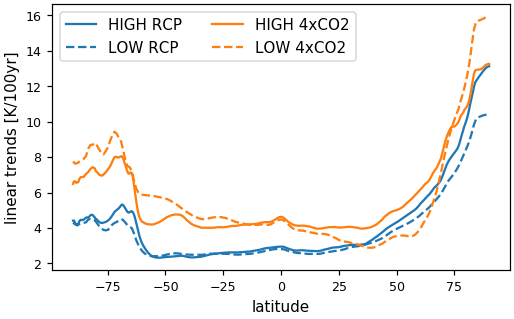

In [9]:
plt.plot(T_rcp.lat, xr_linear_trend(T_rcp.mean('lon'))*365*100, ls='-' , c='C0', label='HIGH RCP'  )
plt.plot(T_lr1.lat, xr_linear_trend(T_lr1.mean('lon'))*365*100, ls='--', c='C0', label='LOW RCP'   )
plt.plot(T_hq .lat, xr_linear_trend(T_hq .mean('lon'))*365*100, ls='-' , c='C1', label='HIGH 4xCO2')
plt.plot(T_lq .lat, xr_linear_trend(T_lq .mean('lon'))*365*100, ls='--', c='C1', label='LOW 4xCO2' )
plt.legend(ncol=2)
plt.ylabel('linear trends [K/100yr]')
plt.xlabel('latitude')

In [10]:
plt.plot(T_rcp.lat, (T_rcp.isel(time=slice(-11,-1)).mean('time')-T_ctrl.mean('lon'), ls='-' , c='C0', label='HIGH RCP'  )
plt.plot(T_lr1.lat, (T_lr1.isel(time=slice(-11,-1)).mean('time')-T_lpd5.mean('lon'), ls='--', c='C0', label='LOW RCP'   )
plt.plot(T_hq .lat, (T_hq .isel(time=slice(-11,-1)).mean('time')-T_ctrl.mean('lon'), ls='-' , c='C1', label='HIGH 4xCO2')
plt.plot(T_lq .lat, (T_lq .isel(time=slice(-11,-1)).mean('time')-T_lpd1.mean('lon'), ls='--', c='C1', label='LOW 4xCO2' )
plt.legend(ncol=2)
plt.ylabel('(last decade)-CTRL [K]')
plt.xlabel('latitude')

SyntaxError: invalid syntax (<ipython-input-10-d8431cd35b54>, line 1)

The LOW 4xCO2 Arctic warms dramatically despite near AMOC collapse (much steeper gradient), that could mean, atmospheric heat flux much greater, or local feedbacks much stronger.

## maps of SAT trends / difference

In [8]:
T_rcp_diff = regridder(T_rcp.isel(time=slice(-11,-1)).mean('time')-T_ctrl)
T_lr1_diff = T_lr1.isel(time=slice(-11,-1)).mean('time')-T_lpd5
T_hq_diff  = regridder(T_hq .isel(time=slice(-11,-1)).mean('time')-T_ctrl)
T_lq_diff  = T_lq .isel(time=slice(-11,-1)).mean('time')-T_lpd1

T_rcp_trend = (xr_2D_trends(T_rcp)*100*365)
T_lr1_trend = (xr_2D_trends(T_lr1)*100*365)
T_hq_trend  = (xr_2D_trends(T_hq )*100*365)
T_lq_trend  = (xr_2D_trends(T_lq )*100*365)

/home/ajueling/.conda/envs/CESM/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/home/ajueling/.conda/envs/CESM/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


now


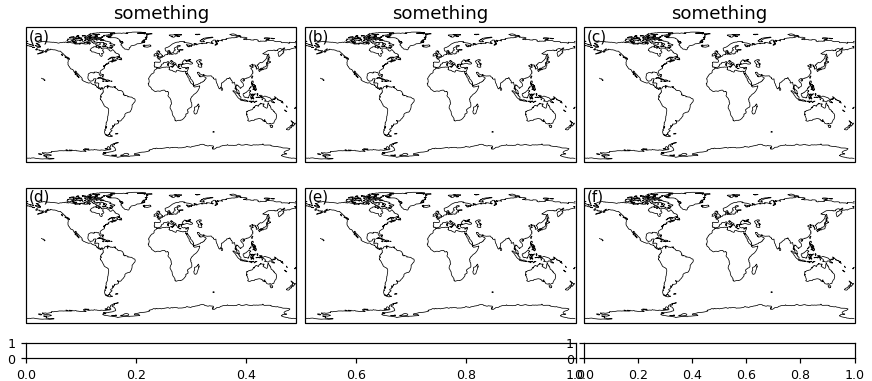

In [11]:
letters = 'abcdef'
f = plt.figure(figsize=(8,3.5))
for i in range(3):
    for j in range(2):
        ax = f.add_axes([.03+i*.32,.55-j*.42,.31,.4], projection=ccrs.PlateCarree())
        ax.coastlines(lw=.5)
        ax.text(.01,.9, '('+letters[i+j*3]+')', transform=ax.transAxes)

        # ax.set_xticks([])
        # ax.set_yticks([])
        if j==0:
            ax.set_title('something')
        if i==0:
            ax.set_ylabel('something')
        if i==0 and j==0:
            print('now')
            cax = f.add_axes([.03,.06,.63,.04])
            cax = f.add_axes([.67,.06,.31,.04])

/home/ajueling/.conda/envs/CESM/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
/home/ajueling/.conda/envs/CESM/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
/home/ajueling/.conda/envs/CESM/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained

CPU times: user 6.42 s, sys: 2.07 s, total: 8.49 s
Wall time: 7.79 s


/home/ajueling/.conda/envs/CESM/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


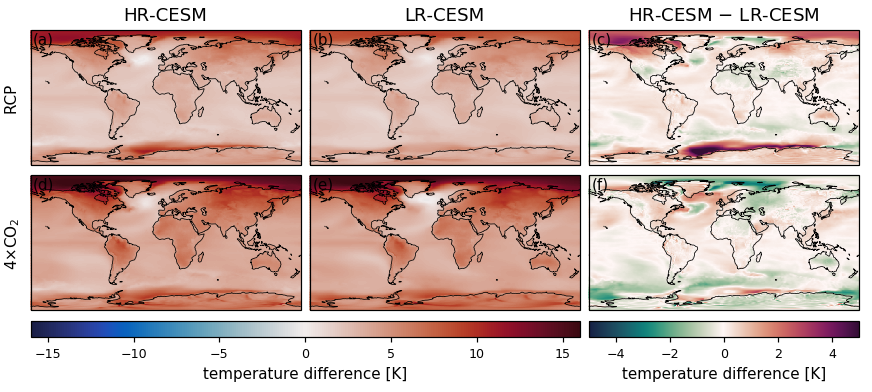

In [17]:
%%time
X, Y = np.meshgrid(T_lr1.lon, T_lr1.lat)

def comparison_maps(xa_list, kw1, kw2, label1=None, label2=None, fn=None):
    """ makes 2x3 maps comparing HIGH/LOW RCP/4xCO2 runs"""
    f = plt.figure(figsize=(8,3.6))
    for i, run in enumerate(['HR-CESM','LR-CESM',r'HR-CESM $-$ LR-CESM']):
        for j, scenario in enumerate(['RCP', r'4$\times$CO$_2$']):
#             if i!=1 and j is not in [1,2]:  continue
            xa = xa_list[j][i]
            ax = f.add_axes([.035+i*.32,.55-j*.37,.31,.4], projection=ccrs.PlateCarree())
            if j==0:  ax.set_title(run)
            if i==0:  ax.text(-.1,.5, scenario, transform=ax.transAxes, rotation=90, va='center')
            # ax.set_ylabel(scenario)
            if i<2:  kw = kw1
            else:    kw = kw2

            im = ax.pcolormesh(X, Y, xa, **kw)
            ax.coastlines(lw=.5)
            ax.text(.01,.9, '('+letters[i+j*3]+')', transform=ax.transAxes)
            if i==0 and j==0:
                cax = f.add_axes([.035,.14,.63,.04])
                plt.colorbar(im, cax=cax, orientation='horizontal', label=label1)
            if i==2 and j==0:
                cax = f.add_axes([.675,.14,.31,.04])
                plt.colorbar(im, cax=cax, orientation='horizontal', label=label2)
            if fn is not None:
                plt.savefig(fn)
    return

# comparison_maps()

xa_list = [[T_rcp_diff, T_lr1_diff, T_rcp_diff - T_lr1_diff],
           [T_hq_diff , T_lq_diff , T_hq_diff  - T_lq_diff ]]
kw1 = {'vmin':-16, 'vmax':16, 'cmap':'cmo.balance'}
kw2 = {'vmin':-5, 'vmax':5, 'cmap':'cmo.curl'}
label = 'temperature difference [K]'
fn = f'{path_results}/thesis/63_dSAT_maps'
comparison_maps(xa_list, kw1, kw2, label1=label, label2=label, fn=fn)

# xa_list = [[T_rcp_trend, T_lr1_trend, regridder(T_rcp_trend) - T_lr1_trend],
#            [T_hq_trend, T_lq_trend, regridder(T_hq_trend) - T_lq_trend]]
# kw1 = {'vmin':-15, 'vmax':15, 'cmap':'cmo.balance'}
# kw2 = {'vmin':-5, 'vmax':5, 'cmap':'cmo.curl'}
# label = 'temperature trend [K/100yr]'
# comparison_maps(xa_list, kw1, kw2, label, label)
# plt.savefig(f'{path_results}/thesis/63_trendSAT_maps')
